github link: https://github.com/ShlomiFridman/PhoenixProject2025

In [ ]:
!pip install requests beautifulsoup4
!pip install requests beautifulsoup4 nltk
!pip install firebase

In [ ]:
import requests
import time
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup
from urllib.robotparser import RobotFileParser
from nltk.stem import PorterStemmer
import re
from firebase import firebase

firebase link

In [ ]:
FBconn = firebase.FirebaseApplication('https://phoenixhw2-default-rtdb.europe-west1.firebasedatabase.app/',None)

functions for building an index for a page

In [ ]:
def index_words(soup):
    index = {}
    words = re.findall(r'\w+', soup.get_text())
    for word in words:
        word = word.lower()
        if word in index:
            index[word] += 1
        else:
            index[word] = 1
    return index

def remove_stop_words(index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to'}
    for stop_word in stop_words:
        if stop_word in index:
            del index[stop_word]
    return index

def apply_stemming(index):
    stemmer = PorterStemmer()
    stemmed_index = {}
    for word, count in index.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
            stemmed_index[stemmed_word] += count
        else:
            stemmed_index[stemmed_word] = count
    return stemmed_index

functions to handle the crawling

In [ ]:
# Function to fetch and parse the robots.txt file to check permissions
def check_robot(url):
    robot_url = urljoin(url, '/robots.txt')
    rp = RobotFileParser()
    rp.set_url(robot_url)
    # Fetch and parse robots.txt file
    rp.read()
    return rp

In [ ]:
# Function to fetch and parse a page
def fetch_page_crawler(url, rp):
    # Check if the URL is allowed to be crawled according to robots.txt
    if not rp.can_fetch('*', url):  # '*' means all user agents
        print(f"Blocked by robots.txt: {url}")
        return None

    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()  # Will raise an exception for 4xx or 5xx responses
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

In [ ]:
# Function to extract internal links from a page
def extract_links(page_content, base_url):
    soup = BeautifulSoup(page_content, 'html.parser')
    links = set()

    # Find all anchor tags and extract the href attribute
    for anchor in soup.find_all('a', href=True):
        href = anchor['href']

        # Resolve relative URLs to absolute URLs
        full_url = urljoin(base_url, href)

        # Only add links that are within the same domain (ibm.com)
        if urlparse(full_url).netloc == urlparse(base_url).netloc:
            links.add(full_url)

    return links

In [ ]:
# Function to crawl a website and fetch n pages
def crawl_website(base_url, max_pages):
    rp = check_robot(base_url)  # Check the robots.txt file
    crawled_urls = set()  # Set to avoid revisiting pages
    urls_to_crawl = [base_url]  # Initialize the queue with the base URL
    crawled_count = 0  # Counter for the number of crawled pages
    urls_index = {}
    ignore_urls = ["form", "mp3", "mp4", "downloads"]

    while urls_to_crawl and crawled_count < max_pages:
        current_url = urls_to_crawl.pop(0)

        if current_url in crawled_urls:
            continue  # Skip already crawled URLs

        print(f"Crawling {crawled_count+1}: {current_url}")
        page_content = fetch_page_crawler(current_url, rp)

        if page_content:
            crawled_urls.add(current_url)
            crawled_count += 1

            # Extract and queue new links to crawl
            new_links = extract_links(page_content, base_url)
            for link in new_links:
                cond1 = any(bad_url in link for bad_url in ignore_urls)
                cond2 = any(u for u in crawled_urls if (f"{u}#" in link))
                cond = cond1 or cond2
                if link not in crawled_urls and link not in urls_to_crawl and not cond:
                    urls_to_crawl.append(link)

            soup = BeautifulSoup(page_content, 'html.parser')
            u_index = index_words(soup)
            u_index = remove_stop_words(u_index)
            u_index = apply_stemming(u_index)
            urls_index[current_url] = u_index
            # Delay between requests to avoid overwhelming the server
            time.sleep(2)  # Sleep for 2 seconds between requests (politeness)

    print(f"\nCrawled {crawled_count} pages.")
    return crawled_urls, urls_index

firebase functions

In [ ]:
def get_index_from_DB():
  return FBconn.get('/Index/', None)

In [ ]:
def update_index_in_db(index_p):
  for k,v in index_p.items():
    FBconn.put("/Index/", k, v)
    print(f"update made:\n\tIndex={k}\ntValues={v}")
  print("Updated given index in DB")

The index we defined

In [ ]:
init_index = [
    'Private',
    'Public',
    'Hybrid',
    'Service',
    'Platform',
    'Infrastructure',
    'Study',
    'Case',
    'Chatbot',
    'Engine',
    'Cloud',
    'Monitor',
    'Data',
    'Mainframe',
    'Performance',
    'Security',
    'SLA',
    'KPI',
    'SOA',
    'Information',
    'Kafka',
    'SQL',
    'Technology',
    'Database',
    'Docker',
    'Kubernetes',
    'RabbitMQ',
    'IBM',
    'Google',
    'Amazon',
    'AI',
]

Processing the index and saving it in DB

In [ ]:
stemmer = PorterStemmer()
stemmed_init_index = {}
for i in init_index:
  stemmed_i = stemmer.stem(i)
  stemmed_init_index[stemmed_i] = {"term":i, "DocIDs": [], "DocIDs_cntrs": []}

update_index_in_db(stemmed_init_index)

update made:
	Index=privat
tValues={'term': 'Private', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Index=public
tValues={'term': 'Public', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Index=hybrid
tValues={'term': 'Hybrid', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Index=servic
tValues={'term': 'Service', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Index=platform
tValues={'term': 'Platform', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Index=infrastructur
tValues={'term': 'Infrastructure', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Index=studi
tValues={'term': 'Study', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Index=case
tValues={'term': 'Case', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Index=chatbot
tValues={'term': 'Chatbot', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Index=engin
tValues={'term': 'Engine', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Index=cloud
tValues={'term': 'Cloud', 'DocIDs': [], 'DocIDs_cntrs': []}
update made:
	Inde

In [ ]:
# Set the base URL for the IBM website or any other URL to crawl
BASE_URL = 'https://www.ibm.com/us-en'

# To limit the number of pages to crawl
MAX_PAGES = 200

urls, urls_index = crawl_website(BASE_URL, MAX_PAGES)

Crawling 1: https://www.ibm.com/us-en
Crawling 2: https://www.ibm.com/consulting?lnk=ProdC
Crawling 3: https://www.ibm.com/watsonx/developer/?lnk=dev
Crawling 4: https://www.ibm.com/impact/ai-ethics?lnk=bus
Crawling 5: https://www.ibm.com/granite?lnk=dev
Crawling 6: https://www.ibm.com/products/watsonx-code-assistant?lnk=dev
Crawling 7: https://www.ibm.com/thought-leadership/institute-business-value/report/ceo-generative-ai?lnk=bus
Error fetching https://www.ibm.com/thought-leadership/institute-business-value/report/ceo-generative-ai?lnk=bus: HTTPSConnectionPool(host='www.ibm.com', port=443): Read timed out. (read timeout=5)
Crawling 7: https://www.ibm.com/think/reports/ai-in-action?lnk=bus
Crawling 8: https://www.ibm.com/hybrid-cloud?lnk=ProdC
Crawling 9: https://www.ibm.com/artificial-intelligence?lnk=ProdC
Crawling 10: https://www.ibm.com/consulting/aws
Crawling 11: https://www.ibm.com/consulting/advantage
Crawling 12: https://www.ibm.com/consulting/sap
Crawling 13: https://www.ibm.

In [ ]:
index_from_DB = get_index_from_DB()
for k,v in index_from_DB.items():
  v['DocIDs'] = []
  v['DocIDs_cntrs'] = []
print(index_from_DB)

{'ai': {'term': 'AI', 'DocIDs': [], 'DocIDs_cntrs': []}, 'amazon': {'term': 'Amazon', 'DocIDs': [], 'DocIDs_cntrs': []}, 'case': {'term': 'Case', 'DocIDs': [], 'DocIDs_cntrs': []}, 'chatbot': {'term': 'Chatbot', 'DocIDs': [], 'DocIDs_cntrs': []}, 'cloud': {'term': 'Cloud', 'DocIDs': [], 'DocIDs_cntrs': []}, 'data': {'term': 'Data', 'DocIDs': [], 'DocIDs_cntrs': []}, 'databas': {'term': 'Database', 'DocIDs': [], 'DocIDs_cntrs': []}, 'docker': {'term': 'Docker', 'DocIDs': [], 'DocIDs_cntrs': []}, 'engin': {'term': 'Engine', 'DocIDs': [], 'DocIDs_cntrs': []}, 'googl': {'term': 'Google', 'DocIDs': [], 'DocIDs_cntrs': []}, 'hybrid': {'term': 'Hybrid', 'DocIDs': [], 'DocIDs_cntrs': []}, 'ibm': {'term': 'IBM', 'DocIDs': [], 'DocIDs_cntrs': []}, 'inform': {'term': 'Information', 'DocIDs': [], 'DocIDs_cntrs': []}, 'infrastructur': {'term': 'Infrastructure', 'DocIDs': [], 'DocIDs_cntrs': []}, 'kafka': {'term': 'Kafka', 'DocIDs': [], 'DocIDs_cntrs': []}, 'kpi': {'term': 'KPI', 'DocIDs': [], 'DocI

In [ ]:
for u,u_vals in urls_index.items():
    print(f"Indexing url={u}")
    # soup = fetch_page(u)
    # if soup is None:
    #     continue
    # index = index_words(soup)
    # index = remove_stop_words(index)
    # index = apply_stemming(index)
    for our_ind, our_ind_vals in index_from_DB.items():
      if our_ind in u_vals:
        our_ind_vals['DocIDs'].append(u)
        our_ind_vals['DocIDs_cntrs'].append(u_vals[our_ind])

print("Finish indexing process")

Indexing url=https://www.ibm.com/us-en
Indexing url=https://www.ibm.com/consulting?lnk=ProdC
Indexing url=https://www.ibm.com/watsonx/developer/?lnk=dev
Indexing url=https://www.ibm.com/impact/ai-ethics?lnk=bus
Indexing url=https://www.ibm.com/granite?lnk=dev
Indexing url=https://www.ibm.com/products/watsonx-code-assistant?lnk=dev
Indexing url=https://www.ibm.com/think/reports/ai-in-action?lnk=bus
Indexing url=https://www.ibm.com/hybrid-cloud?lnk=ProdC
Indexing url=https://www.ibm.com/artificial-intelligence?lnk=ProdC
Indexing url=https://www.ibm.com/consulting/aws
Indexing url=https://www.ibm.com/consulting/advantage
Indexing url=https://www.ibm.com/consulting/sap
Indexing url=https://www.ibm.com/consulting/technology
Indexing url=https://www.ibm.com/thought-leadership/institute-business-value/report/business-trends-2025
Indexing url=https://www.ibm.com/consulting/microsoft
Indexing url=https://www.ibm.com/consulting/oracle
Indexing url=https://www.ibm.com/thought-leadership/institute

In [ ]:
for ind,vals in index_from_DB.items():
  urls_str = '\n\t\t'.join(vals['DocIDs'])
  print(f"Index: '{ind}'\n\tTotal Count: {sum(vals['DocIDs_cntrs'])}\n\tUrls: {urls_str}")

Index: 'ai'
	Total Count: 4960
	Urls: https://www.ibm.com/us-en
		https://www.ibm.com/consulting?lnk=ProdC
		https://www.ibm.com/watsonx/developer/?lnk=dev
		https://www.ibm.com/impact/ai-ethics?lnk=bus
		https://www.ibm.com/granite?lnk=dev
		https://www.ibm.com/products/watsonx-code-assistant?lnk=dev
		https://www.ibm.com/think/reports/ai-in-action?lnk=bus
		https://www.ibm.com/hybrid-cloud?lnk=ProdC
		https://www.ibm.com/artificial-intelligence?lnk=ProdC
		https://www.ibm.com/consulting/aws
		https://www.ibm.com/consulting/advantage
		https://www.ibm.com/consulting/sap
		https://www.ibm.com/consulting/technology
		https://www.ibm.com/thought-leadership/institute-business-value/report/business-trends-2025
		https://www.ibm.com/consulting/microsoft
		https://www.ibm.com/consulting/oracle
		https://www.ibm.com/thought-leadership/institute-business-value/en-us/report/state-of-salesforce-2024
		https://www.ibm.com/garage
		https://www.ibm.com/resources/consulting/sap-insights
		https://ww

In [ ]:
update_index_in_db(index_from_DB)

update made:
	Index=ai
tValues={'term': 'AI', 'DocIDs': ['https://www.ibm.com/us-en', 'https://www.ibm.com/consulting?lnk=ProdC', 'https://www.ibm.com/watsonx/developer/?lnk=dev', 'https://www.ibm.com/impact/ai-ethics?lnk=bus', 'https://www.ibm.com/granite?lnk=dev', 'https://www.ibm.com/products/watsonx-code-assistant?lnk=dev', 'https://www.ibm.com/think/reports/ai-in-action?lnk=bus', 'https://www.ibm.com/hybrid-cloud?lnk=ProdC', 'https://www.ibm.com/artificial-intelligence?lnk=ProdC', 'https://www.ibm.com/consulting/aws', 'https://www.ibm.com/consulting/advantage', 'https://www.ibm.com/consulting/sap', 'https://www.ibm.com/consulting/technology', 'https://www.ibm.com/thought-leadership/institute-business-value/report/business-trends-2025', 'https://www.ibm.com/consulting/microsoft', 'https://www.ibm.com/consulting/oracle', 'https://www.ibm.com/thought-leadership/institute-business-value/en-us/report/state-of-salesforce-2024', 'https://www.ibm.com/garage', 'https://www.ibm.com/resource

<ipython-input-21-1c2e9d108283>:16: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.barplot(x="Index", y="Appearances",


<Figure size 640x480 with 0 Axes>

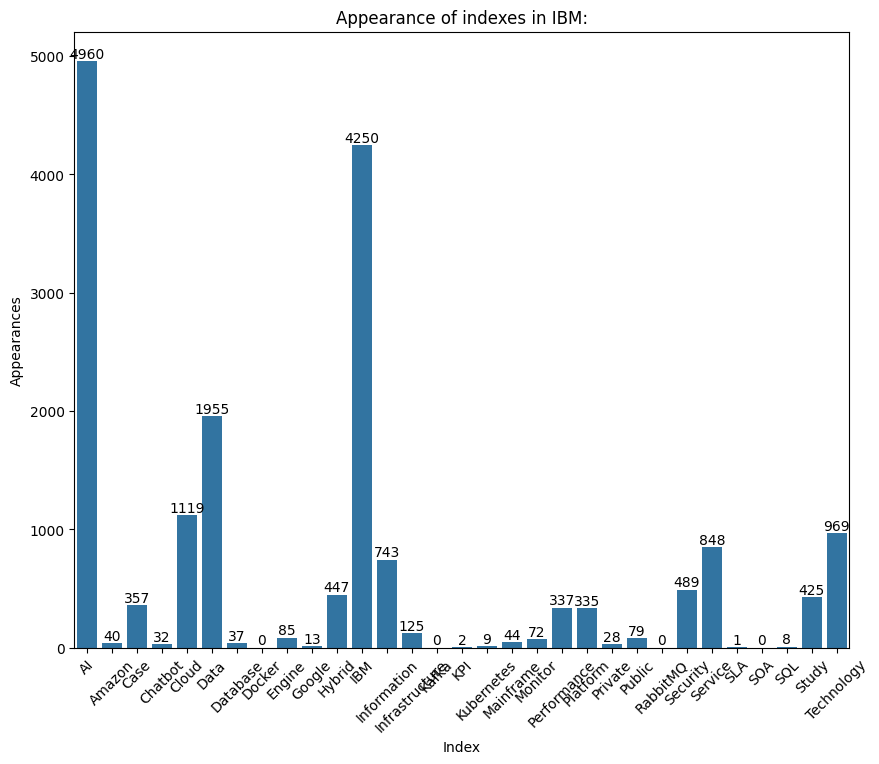

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ind_names = [ind["term"] for ind in index_from_DB.values()]
ind_cntrs = [sum(ind["DocIDs_cntrs"]) for ind in index_from_DB.values()]
ind_data = pd.DataFrame({
    "Index":ind_names,
    "Appearances":ind_cntrs
})

plt.clf()  # Clear the current figure
plt.figure(figsize=(10, 8))  # Increased figure size to accommodate labels
plt.title("Appearance of indexes in IBM:")

ax = sns.barplot(x="Index", y="Appearances",
                 errwidth=0, data=ind_data)
for i in ax.containers:
  ax.bar_label(i,)
plt.xticks(rotation=45)
plt.show()  # Add this to display the plot
plt.close()  # Close the figure to free memory

In [ ]:
searchHistory = []

TODO search engine by text field, you can use the code from exercise 6, save the search history

TODO 3 tabs: search results, graph that shows the rank of each page, graph for the website cover of the query keywords

TODO add the group logo from drive

TODO enable shering, make the link public